In [1]:
import os
import sys
import json
from iconic_tools.langchain import InstructSonnet, InstructOpus3, InstructGPT4, InstructGeminiPro, InstructGPT35
from langchain_core.prompts import ChatPromptTemplate

/Users/murrayshanahan/iconic_dir/antdemo-server/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONSTANTS AND INITIALISATION


PATH = os.path.abspath(os.getcwd())

EVAL_MODEL = InstructGPT4(temperature=1.0, max_tokens=3000)

# GAME = "troy"
# SCENE = "achilles"
# ACTORS = ["Achilles", "Odysseus"]

# GAME = "amadeus"
# SCENE = "constanze"
# ACTORS = ["Mozart", "Constanze", "Schikaneder"]

RED = '\033[91m'
GREEN = '\033[92m'
BLUE = '\033[94m'
YELLOW = '\033[93m'
WHITE = '\033[0m'

In [3]:
# UTILITIES


def print_header(game, scene, model_name):
    print(WHITE + "Game or movie: {}".format(game))
    print("Scene name: {}".format(scene))
    print("Dialogue model: {}".format(model_name))


def load_prompt(filename):
    with open(PATH + f"/prompts/{filename}") as f:
        prompt = f.read()
    return prompt


def read_transcript(filename):
    with open(PATH + f"/transcripts/{filename}") as f:
        dialogue = f.read().strip()
    return dialogue

def list_to_text(L):
    if L == "":
        return ""
    elif len(L) == 1:
        return L[0]
    elif len(L) == 2:
        return f"{L[0]} and {L[1]}"
    else:
        return ", ".join(L[:-1]) + f", and {L[-1]}"

def split_text(text):
    # Split the text by double newlines
    paragraphs = text.split('\n\n')
    # Remove leading or trailing whitespacen  and remove empty paragraphs
    paragraphs = [p.strip() for p in paragraphs]
    paragraphs = [p for p in paragraphs if p]
    return paragraphs


def read_tests(filename):
    tests = split_text(load_prompt(filename))
    tests = [s.strip() for s in tests if not s.strip().startswith('#')]
    return tests


def prompt_llm(prompt, model):
    prompt = ChatPromptTemplate.from_template(template=prompt)
    chain = prompt | model
    return chain

In [4]:
# PROMPTS

eval_preamble_template = """
{instruction_prefix}
This is the game back story. {back_story}\n
The characters in the dialogue are {actors}.
"""

instruction_template = """
{preamble}
Here is the dialogue so far\n\n
{dialogue}
{instruction_suffix}
"""

eval_instruction_prefix = """
You are going to answer a single question about the current state of the dialogue in a scene in the middle of a computer game.
"""

eval_instruction_suffix_template = """
Now consider the following statement about this dialogue. {statement} Is this statement true or false? Answer with a single word, true or false.
"""

In [5]:
# DIALOGUE EVALUATION


def load_prompts(game, scene):
    """Loads prompts for evaluation, including three kinds of test."""
    back_story = load_prompt(game + "/back_story.txt")
    goal_tests = read_tests(game + "/scenes/" + scene + "_scene/" + scene + "_goal_tests.txt")
    style_tests = read_tests(game + "/scenes/" + scene + "_scene/" + scene + "_style_tests.txt")
    synergy_tests = read_tests("synergy_tests.txt")
    return (back_story, goal_tests, style_tests, synergy_tests)


def run_dialogue_tests(preamble, dialogue, model, tests):
    """Carries out a seqeuence of tests on the give dialogue and returns the pass rate."""
    
    passes = 0
    fails = 0

    for statement in tests:            
        instruction = eval_instruction_suffix_template.format(statement=statement)
        prompt = instruction_template.format(
            preamble=preamble, dialogue=dialogue,
            instruction_suffix=instruction)
        chain = prompt_llm(prompt, model)
        response = chain.invoke({})
        # print("Statement: {}".format(statement))
        # print("Result: {}".format(response))
        # print()
        if response[0:4] == "True" or response[0:3] == "true":
            passes += 1
        else:
            fails += 1
    pass_rate = passes / (passes + fails)
 
    return pass_rate


def evaluate_dialogue(game, scene, actors, prompt_method, run_no, dialogue_model_name):
    """Evaluate one saved dialogue."""

    model = EVAL_MODEL

    prompts = load_prompts(game, scene)
    (back_story, goal_tests, style_tests, synergy_tests) = prompts

    preamble = eval_preamble_template.format(
        instruction_prefix=eval_instruction_prefix,
        back_story=back_story,
        scene_description="",
        scene_supplement="",
        actors=list_to_text(actors))

    dialogue = read_transcript((game + "/transcript_" + dialogue_model_name +
                                "_" + prompt_method + "_" + str(run_no) + ".txt"))

    goal_pass_rate = run_dialogue_tests(preamble, dialogue, model, goal_tests)
    print("Goals pass rate {:.2f}".format(goal_pass_rate))
    style_pass_rate = run_dialogue_tests(preamble, dialogue, model, style_tests)
    print("Communication style pass rate {:.2f}".format(style_pass_rate))
    synergy_pass_rate = run_dialogue_tests(preamble, dialogue, model, synergy_tests)
    print("Synergy pass rate {:.2f}".format(synergy_pass_rate))
    print()
    return(goal_pass_rate, style_pass_rate, synergy_pass_rate)


def evaluate_dialogue_baseline(game, scene, actors):
    """Evaluate a baseline dialogue."""

    model = EVAL_MODEL

    prompts = load_prompts(game, scene)
    (back_story, goal_tests, style_tests, synergy_tests) = prompts

    preamble = eval_preamble_template.format(
        instruction_prefix=eval_instruction_prefix,
        back_story=back_story,
        scene_description="",
        scene_supplement="",
        actors=list_to_text(actors))

    dialogue = read_transcript(game + "/transcript_baseline.txt")

    goal_pass_rate = run_dialogue_tests(preamble, dialogue, model, goal_tests)
    print("Goals pass rate {:.2f}".format(goal_pass_rate))
    style_pass_rate = run_dialogue_tests(preamble, dialogue, model, style_tests)
    print("Communication style pass rate {:.2f}".format(style_pass_rate))
    synergy_pass_rate = run_dialogue_tests(preamble, dialogue, model, synergy_tests)
    print("Synergy pass rate {:.2f}".format(synergy_pass_rate))
    print()
    return(goal_pass_rate, style_pass_rate, synergy_pass_rate)


def evaluate_dialogues(game, scene, actors):
    """Evaluate multiple saved dialogues."""

    n_runs = 3
    models = [InstructSonnet(temperature=1.0, max_tokens=3000),
              InstructGPT4(temperature=1.0, max_tokens=3000),
              InstructGeminiPro(temperature=1.0, max_tokens=3000)]
    model_names = ["Sonnet", "GPT4", "GeminiPro"]
    prompt_methods = ["naive", "handmade"]

    results = {"game": game, "scene": scene, "scores": {}}

    for i in range(len(models)):
        dialogue_model_name = model_names[i]
        results["scores"][dialogue_model_name] = {}
        for prompt_method in prompt_methods:
            print_header(game, scene, dialogue_model_name)
            print(WHITE + "Prompt method: {}".format(prompt_method))
            print()
            results["scores"][dialogue_model_name][prompt_method] = {}
            for run_no in range(n_runs):
                print(WHITE + "Run {}".format(run_no))
                print()

                pass_rates = evaluate_dialogue(game, scene, actors, prompt_method, run_no, dialogue_model_name)
                (goal_pass_rate, style_pass_rate, synergy_pass_rate) = pass_rates

                run_name = "run_" + str(run_no)
                results["scores"][dialogue_model_name][prompt_method][run_name] = {}
                results["scores"][dialogue_model_name][prompt_method][run_name]["goal_pass_rate"] = goal_pass_rate
                results["scores"][dialogue_model_name][prompt_method][run_name]["style_pass_rate"] = style_pass_rate
                results["scores"][dialogue_model_name][prompt_method][run_name]["synergy_pass_rate"] = synergy_pass_rate
    
    # Baseline
    print(WHITE + "Game or movie: {}".format(game))
    print("Baseline")
    print()
    pass_rates = evaluate_dialogue_baseline(game, scene, actors)
    (goal_pass_rate, style_pass_rate, synergy_pass_rate) = pass_rates
    results["scores"]["baseline"] = {}
    results["scores"]["baseline"]["goal_pass_rate"] = goal_pass_rate
    results["scores"]["baseline"]["style_pass_rate"] = style_pass_rate
    results["scores"]["baseline"]["synergy_pass_rate"] = synergy_pass_rate

    return results

In [ ]:
# game = "amadeus"
# scene = "constanze"
# actors = ["Mozart", "Constanze", "Schikaneder"]
# scene_version = 0
# run_no = 0
# dialogue_model_name = "sonnet"

# pass_rates = evaluate_dialogue(game, scene, actors, scene_version, run_no, dialogue_model_name)
# (goal_pass_rate, style_pass_rate, synergy_pass_rate) = pass_rates

# print(pass_rates)

In [7]:
# EVALUATE DIALOGUES


scenes =[['amadeus', 'constanze', ["Mozart", "Constanze", "Schikaneder"]],
         ['bound', 'coffee', ["Violet", "Corky"]],
         ['cedar_rapids', 'car', ["Tim", "Ronald", "Dean", "Joan"]],
         ['troy', 'achilles', ["Achilles", "Odysseus"]]]

# scenes =[['amadeus', 'constanze', ["Mozart", "Constanze", "Schikaneder"]]]

# Evaluations
results = []
for (game, scene, actors) in scenes:
    new_results = evaluate_dialogues(game, scene, actors)
    results.append(new_results)

# Save results to file
file = PATH + "/results.json"
with open(file, 'w') as f:
    json.dump(results, f)

# Load results from file
file = PATH + "/results.json"
with open(file, 'r') as f:
    results = json.load(f)

print(json.dumps(results, sort_keys=True, indent=4))

Game or movie: amadeus
Scene name: constanze
Dialogue model: Sonnet
Prompt method: naive

Run 0

Goals pass rate 0.67
Communication style pass rate 1.00
Synergy pass rate 1.00

Run 1

Goals pass rate 0.67
Communication style pass rate 1.00
Synergy pass rate 1.00

Run 2

Goals pass rate 0.67
Communication style pass rate 1.00
Synergy pass rate 1.00

Game or movie: amadeus
Scene name: constanze
Dialogue model: Sonnet
Prompt method: handmade

Run 0

Goals pass rate 1.00
Communication style pass rate 1.00
Synergy pass rate 1.00

Run 1

Goals pass rate 1.00
Communication style pass rate 1.00
Synergy pass rate 1.00

Run 2

Goals pass rate 1.00
Communication style pass rate 1.00
Synergy pass rate 1.00

Game or movie: amadeus
Scene name: constanze
Dialogue model: GPT4
Prompt method: naive

Run 0



KeyboardInterrupt: 

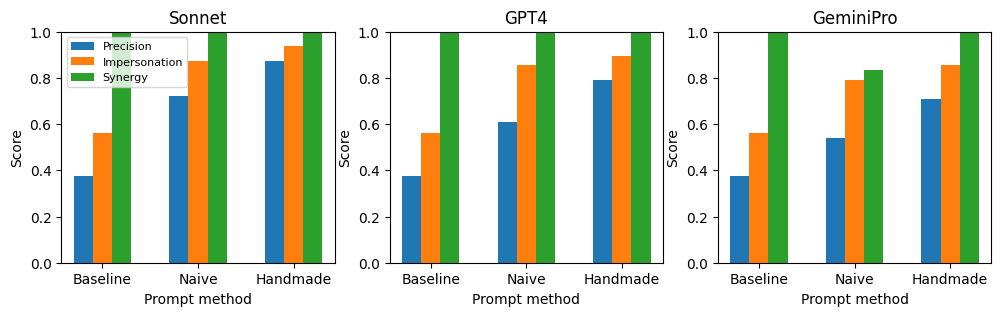

In [52]:
# Plot results


import numpy as np
import matplotlib.pyplot as plt


# Load results from file
file = PATH + "/results.json"
with open(file, 'r') as f:
    results = json.load(f)

n_games = len(results)
n_runs = 3
models = [InstructSonnet(temperature=1.0, max_tokens=3000),
          InstructGPT4(temperature=1.0, max_tokens=3000),
          InstructGeminiPro(temperature=1.0, max_tokens=3000)]
model_names = ["Sonnet", "GPT4", "GeminiPro"]
prompt_methods = ["naive", "handmade"]

# Plot results as bar charts
fig = plt.figure(figsize=(12,3))
for i in range(len(models)):
    model_name = model_names[i]
    goal_means = []
    style_means = []
    synergy_means = []

    # Baselines
    goal_tot = 0
    style_tot = 0
    synergy_tot = 0
    for j in range(n_games):  # for each game/movie scene
        scene_results = results[j]["scores"]
        for run_no in range(n_runs):
            run_name = "run_" + str(run_no)
            goal_tot += scene_results["baseline"]["goal_pass_rate"]
            style_tot += scene_results["baseline"]["style_pass_rate"]
            synergy_tot += scene_results["baseline"]["synergy_pass_rate"]
    goal_mean = goal_tot / n_games
    style_mean = style_tot / n_games
    synergy_mean = synergy_tot / n_games
    goal_means.append(goal_mean)
    style_means.append(style_mean)
    synergy_means.append(synergy_mean)

    for prompt_method in prompt_methods:
        # Find mean scores over all games / movies and runs
        goal_tot = 0
        style_tot = 0
        synergy_tot = 0
        for j in range(n_games):  # for each game/movie scene
            scene_results = results[j]["scores"]
            for run_no in range(n_runs):
                run_name = "run_" + str(run_no)
                goal_tot += scene_results[model_name][prompt_method][run_name]["goal_pass_rate"]
                style_tot += scene_results[model_name][prompt_method][run_name]["style_pass_rate"]
                synergy_tot += scene_results[model_name][prompt_method][run_name]["synergy_pass_rate"]
        goal_mean = goal_tot / (n_games * n_runs)
        style_mean = style_tot / (n_games * n_runs)
        synergy_mean = synergy_tot / (n_games * n_runs)
        goal_means.append(goal_mean)
        style_means.append(style_mean)
        synergy_means.append(synergy_mean)

    # Make the plot
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c']
    plt.subplot(1, 3, i+1)
    x = np.arange(3)
    width = 0.2
    plt.bar(x-0.2, goal_means, width, color=colours[0])
    plt.bar(x, style_means, width, color=colours[1])
    plt.bar(x+0.2, synergy_means, width, color=colours[2])
    plt.ylim([0,1])
    plt.xticks(x, ["Baseline", "Naive", "Handmade"])
    plt.xlabel("Prompt method")
    plt.ylabel("Score")
    if i==0:
        plt.legend(["Precision", "Impersonation", "Synergy"], loc='upper left', fontsize=8)
    plt.title(model_name)

plt.show()
